$\textbf{INTRO}$

Nello scaling dei sistemi di QC c'é concentrazione esponenziale della Loss Function in funzione dei parametri (Barren Plateu). Ciò significa che nello spazio dei parametri, la funzione di loss tende ad essere molto piatta e a convergere velocemente in un unico punto. Quando è presente rumore, la LF non può essere descritta e ottimizzata in PQC con la notazione standard di Lie.

In ultima analisi, il problema sorge dalla dimensionalità (la small angle initialization è una soluzione comune). I BP possono essere indotti anche da noise ambientale e decoerenza (NIBP).

2-design nella computazione quantistica si riferisce a un insieme di stati quantistici o unità che imitano le proprietà statistiche di stati o unità veramente casuali fino al secondo momento (varianza).


$\textbf{VQA}$

I Parameterized Quantum Circuits (PQC) sono circuiti quantistici con parametri variabili, spesso utilizzati in algoritmi ibridi quantistici-classici per affrontare problemi computazionali. Essi rappresentano un ponte tra il calcolo quantistico e l’ottimizzazione classica, costituendo un elemento fondamentale nelle applicazioni quantistiche moderne, come Algoritmi Quantistici Variazionali (VQA) e Modelli di Machine Learning Quantistico.

Le componenti chiave sono Gate Parametrizzati (Porte quantistiche con angoli regolabili) e un ciclo di ottimizzazione classico che regola i parametri per minimizzare/massimizzare una funzione obiettivo.

Gli Algoritmi Variazionali Quantistici (VQA) sono algoritmi ibridi che utilizzano un ottimizzatore classico per addestrare un circuito quantistico parametrizzato al fine di approssimare soluzioni per un determinato problema. Essi richiedono tipicamente un numero ridotto di porte e qubit, rendendoli più resistenti al rumore. Sono iterativi: ogni iterazione include una combinazione di elaborazione quantistica e classica.

L’output (una misura) di un’iterazione viene inviato all’ottimizzatore classico e l’ottimizzatore genera un nuovo input (un parametro) per la successiva iterazione.

Un aspetto cruciale negli algoritmi quantistici variazionali è la scelta dell'**ansatz**, ossia l'architettura del circuito quantistico parametrizzato. La struttura dell'ansatz influisce direttamente sui parametri del circuito e sul modo in cui questi possono essere ottimizzati per minimizzare la funzione di costo.

Le **Funzioni di Costo** ( Loss functions) hanno il compito di mappare i valori dei parametri quantistici in numeri reali. In maniera più astratta, definiscono una ipersuperficie, tale che il compito dell'ottimizzatore è quello di trovare i minimi assoluti su questa. La funzione di costo può essere espressa come una funzione di stati di input iniziali, osservabili e porte unitarie che dipendono dai parametri. Spesso è utile esprimere la funzione di costo come somma di funzioni che dipendono dalla traccia di un osservabile.

$$C(\boldsymbol{\theta}) = \sum_{k} f_k (\, \text{Tr}\left(O_k \rho_k(\boldsymbol{\theta})\right))$$

Una volta definita funzione di costo e ansatz, per allenare i parametri usiamo il gradiente della Loss function.

$\textbf{QML}$

Le reti neurali classiche sono modelli algoritmici ispirati al funzionamento del cervello umano, progettati per riconoscere schemi nei dati e risolvere problemi complessi. Si basano su una serie di nodi interconnessi, o neuroni, organizzati in una struttura a strati. I parametri di questi modelli possono essere appresi utilizzando strategie di addestramento di machine learning o deep learning.

La motivazione alla base del Quantum Machine Learning (QML) è integrare concetti del calcolo quantistico con il machine learning classico, al fine di sviluppare nuovi e migliorati schemi di apprendimento. Le reti neurali quantistiche (QNN) applicano questo principio combinando reti neurali classiche con circuiti quantistici parametrizzati.

Le QNN, come le reti neurali classiche, sono modelli algoritmici che possono essere addestrati per individuare schemi nascosti nei dati. Questi modelli possono caricare dati classici (input) in uno stato quantistico e processarli successivamente con porte quantistiche parametrizzate da pesi variabili. L’output, ottenuto dalla misurazione dello stato quantistico, viene utilizzato in una funzione di perdita per allenare i pesi attraverso il metodo di backpropagation.

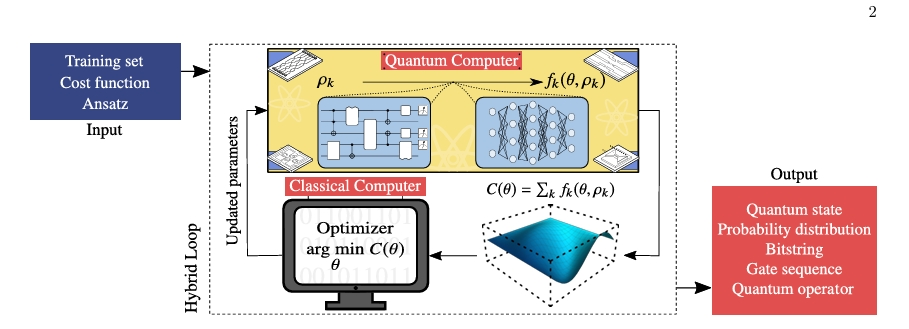

In [ ]:
from IPython.display import Image, display

image5 = "/Users/sebastianopian/Documents/Uni/Magistrale/Qc/QC.exam/Img/Screenshot_23-1-2025_104642_.jpeg"

display(Image(filename=image5, width=600, height=400))

$\textbf{Barren Plateau}$

La crescita esponenziale della dimensione dello spazio di Hilbert associato ad un circuito quantistico e la complessità nella stima del gradiente rendono questa scelta inadeguata per algoritmi ibridi quantistici-classici che operano su più di pochi qubit. In particolare, per una vasta classe di circuiti quantistici parametrizzati ragionevoli, la probabilità che il gradiente lungo una qualsiasi direzione significativa sia diverso da zero, con una precisione fissata, è esponenzialmente piccola in funzione del numero di qubit. Argomentiamo che questo è correlato alla caratteristica di 2-design dei circuiti casuali e che è necessario studiare soluzioni a questo problema.

I barren plateaus sono un fenomeno nei circuiti quantistici parametrizzati (PQC) in cui i gradienti della funzione costo si annullano esponenzialmente all’aumentare del numero di qubit, rendendo difficile l’addestramento degli algoritmi quantistici variazionali.

Cause possibili sono l'inizializzazione casuale che genera distribuzioni altamente uniformi nello spazio di Hilbert e la dimensionalità complessiva del sistema.

Strategie di mitigazione possibili sono Ansatz strutturati, allenare il circuito aggiungendo strati progressivamente,  usare tecniche classiche per inizializzare i parametri vicino a soluzioni ottimali e riformulare le funzioni costo per concentrarsi su parti specifiche dello spazio delle soluzioni.

$\textbf{TEORIA SULLA VARIANZA}$

Con $ \textit{H} = \otimes_{m} H_m$ , $dim(\mathcal{H}) = \Pi_m dim(\mathcal{H}_m)$, con $\mathcal{H}_m$ indichiamo un Q-Bit o un gruppo di qbit e con $\Phi_{\vec{\theta}}$ il canale quantistico (il circuito) che agisce sui Q-bit.

La funzione di costo che viene minimizzata è $\mathcal{L}_{\rho, k}=Tr[\Phi(\rho)H]$, con H osservabile da determinare. Il BP può essere visto dalla varianza di $\mathcal{L}: \textbf{V}_{\rho,H}(\theta)$. Nello specifico, c'è un BP se $\textbf{V} \propto O(e^{-\beta n})$ con n numero di QBIT.

Per un sistema layered scriviamo $\Phi_{\theta}= \mathcal{U_{L+1} \circ E_L \circ U_{L-1} \circ ... \circ E_1}$, dove $\mathcal{U_i}$ sono operatori unitari e $\mathcal{E_i}$ operatori qualsiasi, chiamati "strettamente contrattivi" se($\|E_i\| < 1$).

In generale, lo spazio $H$ può essere suddiviso in sottosistemi locali. Questa suddivisione di $H$ induce una corrispondente partizione dello spazio $B$ degli operatori su $H$. Gli operatori in $B$ vengono raggruppati in sottospazi $B_\kappa$, ciascuno identificato da un vettore binario $\kappa$ (con $\kappa \in \{0, 1\}^M$), che indica su quali sottosistemi locali gli operatori agiscono non trivialmente (dove $\kappa_m = 1$).

Se $\mathcal{B}$ è lo spazio degli operatori limitati su $\mathcal{H}$ , tutte le componenti dei sistemi a strati mappano $\mathcal{B}$ in se stesso. Inoltre $\mathcal{B}$ preserva la suddivisione in sottosistemi di $\mathcal{H}$.

Lo spazio $B$ è scomposto come somma diretta:
$$ B = \bigoplus_{\kappa \in \{0,1\}^M} B_\kappa.$$
La dimensione di ciascun sottospazio $B_\kappa$ è data da:
$ d_\kappa = \prod_m (d_m^2 - 1)^{\kappa_m}$, dove $d_m$ rappresenta la dimensione del sottosistema $H_m$. Il caso speciale $\kappa = 0$ corrisponde ad operatori banali.

Un operatore $A \in B$ si dice \emph{$\kappa$-locale} se appartiene a $B_\kappa$. A ciascun operatore si associa un vettore di località $\ell_A \in {R}^{2^M}$, che descrive quanto l'operatore è distribuito nei vari sottospazi $B_\kappa$. Il vettore di località $\ell_A$ è definito come un vettore di dimensione pari al numero di sottospazi in cui lo spazio $B$ è suddiviso. Ogni componente $(\ell_A)_\kappa$ rappresenta la proiezione dell'operatore $A$ sul sottospazio $B_\kappa$. Questa formula misura la somma dei quadrati delle proiezioni dell'operatore $A$ sugli elementi della base $\{B_j\}_j$, normalizzata rispetto alla dimensione del sottospazio.Questo vettore è calcolato utilizzando una base ortonormale hermitiana $\{B_j\}_j$ di $B_\kappa$, e gli elementi di $\ell_A$ sono definiti come:
$$(\ell_A)_\kappa = \frac{\sum_{j=1}^{d_\kappa} \text{Tr}[B_j A]^2}{d_\kappa}.$$


Se A è un operatore locale il vettore di località assume la forma più semplice:  $(\ell_A)_\lambda = \delta_{\kappa,\lambda} \|A\|_2$

A questo punto siamo interessati a capire quando un operatore lineare che agisce su B preserva la località dello spazio, cioè quanto due sottospazi di B sono messi in comunicazione da un operatore lineare. Questo è importante perché è proprio ciò che causa il rumore: mettere in comunicazione spazi di Hilbert che non vorremmo comunicassero e fa si che il Barren Plateu diventi più importante.

Quando si considera una mappa lineare $\Lambda: B \to B$, si può misurare quanto la mappa preserva o trasferisce la località tra i sottospazi $B_\kappa$ e $B_\lambda$. Questo è rappresentato da una matrice di trasferimento di località $T$, i cui elementi sono definiti come:
$$T_{\kappa,\lambda} = \frac{1}{d_\kappa} \sum_{j=1}^{d_\kappa} (\ell_{\Lambda(B_j)})_\lambda,$$
dove $\ell_{\Lambda(B_j)}$ è il vettore di località associato all'immagine di $B_j$ sotto $\Lambda$.
se $\Lambda$ preserva la località, $T= I$. In questo senso, assumiamo che gli $\mathcal{U}$ siano locali, $\mathcal{E}$ no.

La matrice di trasferimento di località $T$ descrive come una mappa lineare $\Lambda : B \to B$ trasferisce "località" tra i sottospazi $B_\kappa$.
$(\ell_{\Lambda(B_j)})_\lambda$ è la componente $\lambda$-esima del vettore di località associato all'immagine di $B_j$ sotto la mappa $\Lambda$. Ogni elemento $T_{\kappa,\lambda}$ rappresenta l'interazione tra il sottospazio $B_\kappa$ (riga $\kappa$) e il sottospazio $B_\lambda$ (colonna $\lambda$). Valori elevati di $T_{\kappa,\lambda}$ indicano un forte trasferimento di località tra i due sottospazi, mentre valori piccoli indicano che la mappa $\Lambda$ preserva maggiormente la separazione tra di essi.

La matrice $T$ può essere organizzata in blocchi per evidenziare meglio le interazioni tra gruppi di sottospazi. Ad esempio, se i sottospazi $B_\kappa$ sono raggruppati in modo gerarchico, la matrice $T$ può essere scritta come:
$$
T =
\begin{bmatrix}
T^{(1,1)} & T^{(1,2)} & \cdots & T^{(1,n)} \\
T^{(2,1)} & T^{(2,2)} & \cdots & T^{(2,n)} \\
\vdots    & \vdots    & \ddots & \vdots    \\
T^{(n,1)} & T^{(n,2)} & \cdots & T^{(n,n)}
\end{bmatrix},
$$
dove i blocchi diagonali $T^{(i,i)}$ rappresentano la preservazione della località all'interno di ciascun gruppo di sottospazi, mentre i blocchi fuori diagonale $T^{(i,j)}$ con $i \neq j$ descrivono il trasferimento di località tra gruppi distinti. Questa riorganizzazione consente un'analisi dettagliata della struttura locale preservata o modificata dalla mappa $\Lambda$.

In generale, se l'Hamiltoniana rispetta determinate simmetrie, c'è una riduzione dello spazio di Hilbert, in quanto l'ansatz evita gli stati che rompono la simmetria, e dunque si può concentrare l’ottimizzazione in sottospazi significativi più piccoli.
Un modo per mitigare i BP può essere proprio ne rispettare determinate simmetrie, ad es. simmetria rotazionale (applicare rotazioni uniformi a tutti i qubit) o simmetria traslazionale (utilizzare schemi di entanglement nearest-neighbor).

L'obiettivo è definire una varianza, che ci aiuterà a capire il valore del barren Plateau, da cui grazie a calcoli analitici e numerici riusciremo a stabilire un limite minimo per circuiti molto profondi. In pratica avremo uno strumento per quantificare la comparsa del barren plateau in circuiti profondi (a molti layer) e non.

L è il numero dei layers. $E_{\theta}\{.\}$ rappresenta il valore di aspettazione rispetto al parametro $\theta$.
Vale: $E_{\theta}(Tr[\mathcal{U}_{\theta}(\rho)H]^2) = (l_{\rho},l_H)$. Dunque, termini di località diversa non contribuiscono insieme alla varianza, ma si sommano semplicemente.
In generale: $E_{\theta}(Tr[\Phi_{\theta}(\rho)H]^2) = (l_{\rho}, \Pi_{l=1}^{L}T_l l_H)$, dunque:

$$\textbf{V}_{\rho,H}^L = (l_{\rho}, \Pi_{l=1}^{L}T_l l_H) -\frac{Tr[H]^2}{d^2}$$.

Questa formula è inutilizzabile per grandi profondità a causa della sua complessita computazionale, ciò non di meno sarà usata per ricavare il limite a profondità grandi.

\textbf{CIRCUITI PROFONDI}

Per circuiti profondi, il contributo degli autovalori $T_l$ diventa dominante, da questo fenomeno l'interazione tra la parte unitaria e quella non unitaria da' luogo al fenomeno dell'$\textit{assorbimento}$.
Considereremo circuiti dove $\mathcal{E_l = E}$ e dove tutti gli osservabili H hanno traccia nulla, in modo che il secondo termine della varianza sia uguale a zero e che scompaia la sommatoria in favore di L.

Dunque abbiamo una matrice T con tutti gli elementi maggiori o uguali a zero. La parte interessante è che la matrice T può essere scomposta diagonalmente in blocchi essenziali (vedi fig.) e non. In particolare sottospazi di B diversi sono messi in comunicazione dai diversi blocchi essenziali di T. Allora:  

$$\textbf{V}_{\rho,H}^L = (l_{\rho}, T_{l_H}^L)$$.

Definito come $\mathcal{B_z = \oplus_{k\in T_z} B_k }$ e, dato $A \in \mathcal{B}$,  $(l_A)_z = \sum_{k\in T_z} (l_A)_k$.

T gode di tre proprietà: la prima è che i blocchi messi in comunicazione da questa matrice preservano la loro località se trasformati dai canali $\mathcal{E}$, la seconda è che il suo blocco $\mathcal{B_0}$ forma sempre una componente essenziale di T che indichiamo con $\mathcal{T_{0}}$, la terza è che questa matrice è sempre contrattiva, cioè $\mathcal{\rho (T_{z}) \leq 1} \rightarrow (v_z)_k = 1  \forall k$.

Se $L \rightarrow \infty $,

$$V_\infty^{\rho,H} = \sum_z (\ell \rho_z, w_z)(\ell_H)_z + (\ell \rho_z, w_z)(A \ell_H)_z$$.
Dove $w_z$ è autovalore destro di $T_z$.
Semplificando ulteriormente il problema al caso in cui il canale epsilon è formato da rumore sui singoli rumori e da canali unitari, $\mathcal{E = N \cdot W}$, allora la varianza assume la forma al limite:

$$V_\infty^{\rho,H} = \sum_z \left( \frac{(\ell \rho)_z (\ell_H)_z}{d_z} + \frac{(\ell \rho)_z (A \ell_{H})_z}{d_z} \right).$$

Sotto le assunzioni fatte, vale:
$$\|\frac{1}{L}\sum_l V_{\rho,H}^L - V_{\rho,H}^{\inf}\| \simeq  e^{-{\beta L}} \|H\|^2 .$$

In generale, non è detto che la varianza converga ad un valore ma almeno rimane limitata.
Questo mette in evidenza come alcuni sottospazi si comportano da attrattori per la varianza. A è la matrice di assorbimento che quantifica il contributo di questi termini (non negativi).

L'interazione tra i Layer unitari e rumorosi propaga $\mathcal{E}$ alle componenti irriducibili, i canali unitari risentono maggiormente di questo effetto in quanto manca il termine di assorbimento.

In sostanza, la varianza tende subito al valore di massimo per come sono fatte. Abbiamo visto che per qualche motivo il termine dominante è dato dalla matrice di assorbimento che dopo abbiamo chiamato A. Infine, possiamo dire che date queste due cose, tanto più grande è il valore di A sullo spazio vettoriale, il valore di A è tanto maggiore tanto più grande è il centramento tra i vari canali quantistici dunque tanto piu grandi sono i sottospazi essenziali. Da cui la necessita di centrare il piu possibile questi spazi.

\textbf{CIRCUITI PICCOLI}

Non possiamo più in questo caso assumere che la convergenza sia raggiunta da subito e le approssimazioni fatte non valgono più. Dovremo limitarci a cercare un lower bound per $V^L$. Il trucco è studiare diverse situazioni in cui la varianza converge velocemente. La richiesta è che $\beta L \simeq log(n)$, ovvero che il circuito abbia pochi layer, in questo modo $V^{\infty}$ non è mai raggiunto. $\beta$ dipende dalle correlazioni non locali.
Questa condizione di lentezza è data dal seguente teorema:

Dati $\mathcal{E_{l}}, \mathcal{T_{l}}$ e $\alpha_l= min_{\mathcal{k} \in K}(T_l)_{\mathcal{k,k}}$. allora:

$$V_L^{\rho,H} \geq   \alpha^L (l_{\rho},l_{\mathcal{K(H)}})$$


Dove $\mathcal{K}$ è il proiettore su  $\mathcal{B}_K = \oplus_{\mathcal{k}\in K} \mathcal{B_k}$ e $\alpha$ è la media degli $\alpha_l$.

Inoltre, se: $  \alpha >0 \ e \ L \simeq logn \ \ \ o  \ \ \ \alpha= 1 - f(n,L) \ con \ f\simeq log(n)/L$, allora:

$$V_L^{\rho,H} \geq  F(n) (l_{\rho},l_{\mathcal{K(H)}})$$

dove $F \simeq 1/poly(n)$.

Questi risultati sono stati ottenuti per T circa I, simile alla condizione dei piccoli angoli.


\textbf{NOISE AD ENTANGLEMENT}


Osservando la struttura di A, possiamo vedere come scala la varianza come funzione del rumore e dell'entanglement. Consideriamo $\mathcal{E}_c(\rho) = (1-p)\mathcal{E}(\rho) + p\tilde{\rho}$ dove  $\tilde{\rho}$ è uno stato arbitrario, E è un canale unitario che rappresenta l'entanglement, p l'errore. Possiamo pensare a $\Phi(\rho)= (1-p)\rho + p\tilde{\rho}$ e $\mathcal{E \circ U}$

$$V_{\inf}^{\rho,H} \geq   p^2(l_{\\tilde{\\rho}}(I-(1-p)^2T)l_H)$$

e se T è un proiettore,

$$V_{\inf}^{\rho,H} \geq (p/(2-p)-p^2)(l_{\tilde{\rho}}, Tl_H) + p^2(l_{\tilde{\rho}}, l_H)$$

Notiamo che è scomparsa la dipendenza dallo stato iniziale. Solo i layer dopo un certo l contribuiscono sensibilmente alla varianza.

Sia $\mathcal{E}_c$ un canale quantistico con $0 < p \leq 1$, e sia $T$ la matrice di transizione associata a $\mathcal{E}_c^\dagger$. Allora:

$$V_\infty^{\rho, H} = p^2 \left( \ell_{\tilde{\rho}}, \left( I - (1-p)^2 T \right)^{-1} \ell_H \right).$$

In particolare, se $T$ è una proiezione, allora:

$$V_\infty^{\rho, H} = \left(p^2 - p - p^2 \right) \left( \ell_{\tilde{\rho}}, T \ell_H \right) + p^2 \left( \ell_{\tilde{\rho}}, \ell_H \right)$$.


\textbf{SCELTA DEL SDR PER RISULTATI NUMERICI}


Per simulare il rumore entangling, sono stati usati gli operatori di Kraus. $\rho \rightarrow \Phi(\rho)= \sum_i K_i \rho K_i^+$ con $\sum_i K_i K_i^+ =I$. Se utilizziamo $K_0 = \sqrt{1-p}I, K_1=\sqrt{p}W$. Con probabilità p che venga applicato W, operatore che manda lo stato nel GHZ (stato di massimo entanglement):
$$\tilde{\rho} = \frac{(\vert 0 \rangle^{\otimes n} + \vert 1 \rangle^{\otimes n})(\langle 0 \vert^{\otimes n} + \langle 1 \vert^{\otimes n})}{2^n}$$.
Lo stato iniziale è fissato come $\rho = (\vert 0 \rangle \langle 0 \vert)^{\otimes n}$ a cui vengono applicate una serie di rotazioni su X e Z casuali.

Il canale considerato è della forma $E_c = N \circ E$, dove:
$$E_c(\rho) = (1-p)E(\rho) + p\tilde{\rho},$$

L'utilità è che lo stato GHZ può essere rappresentato da somme di matrici di Pauli rendendolo facilmente computabile.

La parte entangling è rappresentata in Fig. 4. Sebbene il numero di strati $L$ necessari per raggiungere la convergenza a $V^\infty_{\rho, H}$ sia logaritmico, la velocità di mescolamento dipende dalla parte entangling. Per questo motivo, $L = 8$ strati sono sufficienti nel caso di entanglement rapido, mentre $L = 20$ sono necessari per l'entanglement lento.

L'osservabile è fissato come:
$$
H = h \sum_{k=1}^n Z_k \otimes Z_{k+1},
$$
dove il fattore di normalizzazione $h$ è scelto come $h = 9/n$. Questo assicura che:
$$
(\ell_{\tilde{\rho}}, \ell_H) = 1,
$$
rendendo il confronto particolarmente semplice.

Lo stato $\tilde{\rho}$ può essere decomposto utilizzando la base di Pauli normalizzata $\{I, X, Y, Z\}^{\otimes n}$. In particolare, usando le seguenti espressioni:
$$
\vert 0 \rangle \langle 0 \vert = \frac{I + Z}{2}, \quad
\vert 1 \rangle \langle 1 \vert = \frac{I - Z}{2}, \quad
\vert 0 \rangle \langle 1 \vert = \frac{X + iY}{2}, \quad
\vert 1 \rangle \langle 0 \vert = \frac{X - iY}{2},
$$
possiamo scrivere $\tilde{\rho}$ come somma di termini che coinvolgono stringhe di Pauli.

Sfruttando una generalizzazione del teorema binomiale:
$$(A + \omega B)^{\otimes n} = \sum_{j=0}^n \omega^j \sum_{\sigma \in S} \sigma(A^{\otimes (n-j)} \otimes B^{\otimes j}),$$
dove $\omega \in C$ e $\sigma$ rappresenta una permutazione degli ordini dei qubit, otteniamo che:
$$\tilde{\rho} = \frac{1}{2^{n/2}} \sum_{j=0}^{\lfloor n/2 \rfloor} \sum_{\sigma \in S} \sigma(I^{\otimes (n-2j)} \otimes Z^{\otimes 2j}) + (-1)^j \sigma(X^{\otimes (n-2j)} \otimes Y^{\otimes 2j}).$$

Come si nota da questa espressione, $\tilde{\rho}$ ha componenti non nulle solo sulle stringhe di Pauli non banali su tutti i qubit o su un numero pari di qubit. Infine, l'osservabile $H$ scelto consente una semplice verifica dello scaling di $V^\infty_{\rho, H}$, con ogni termine che contribuisce in modo indipendente e normalizzato a $1/(d_m^2-1)^2 = 1/9$, dove $d_m$ è la dimensione del sottosistema.

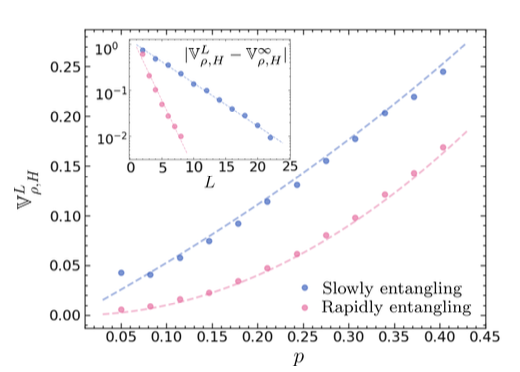

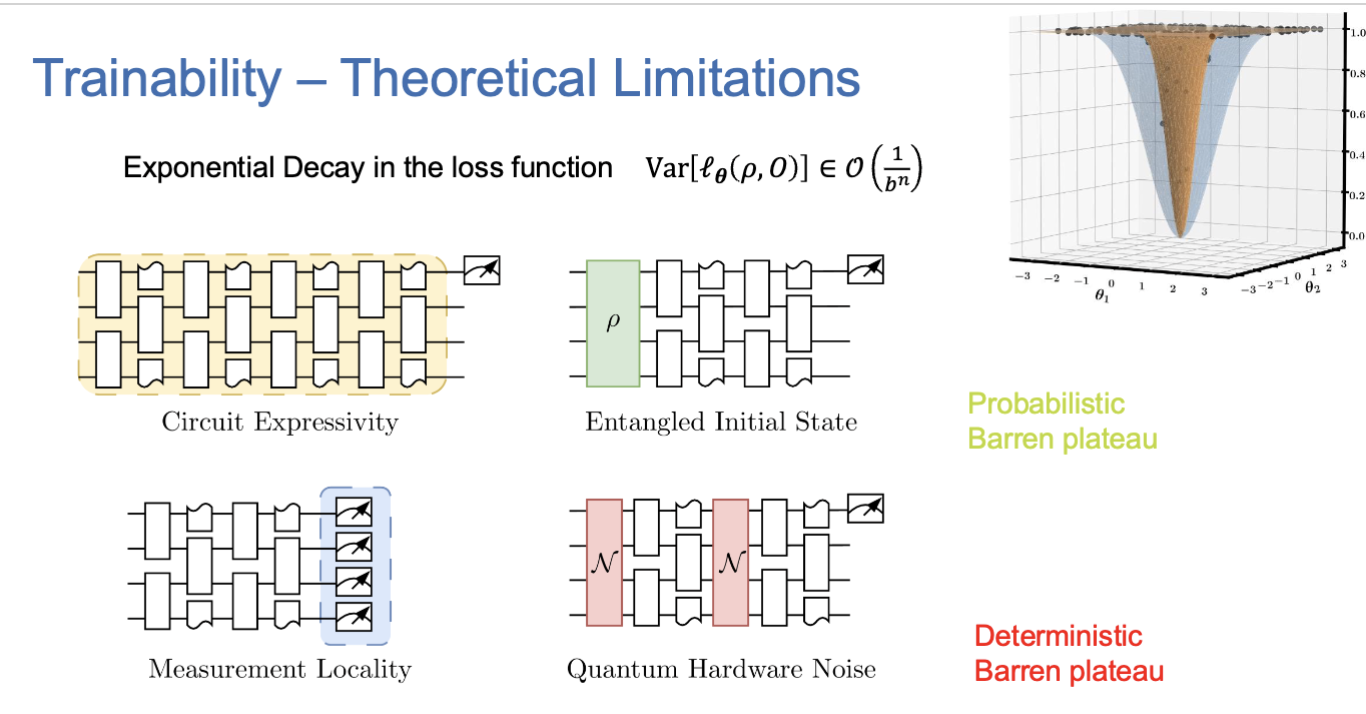

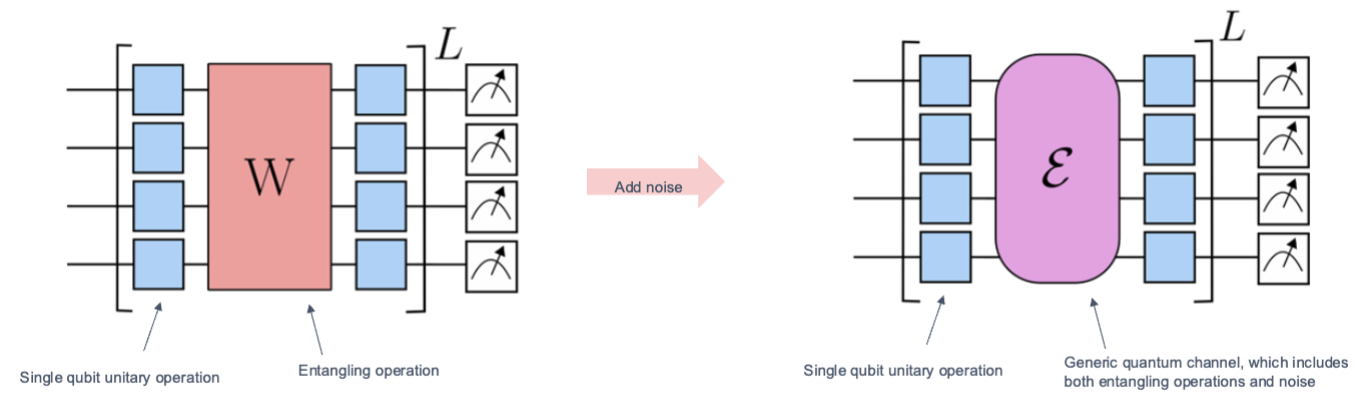

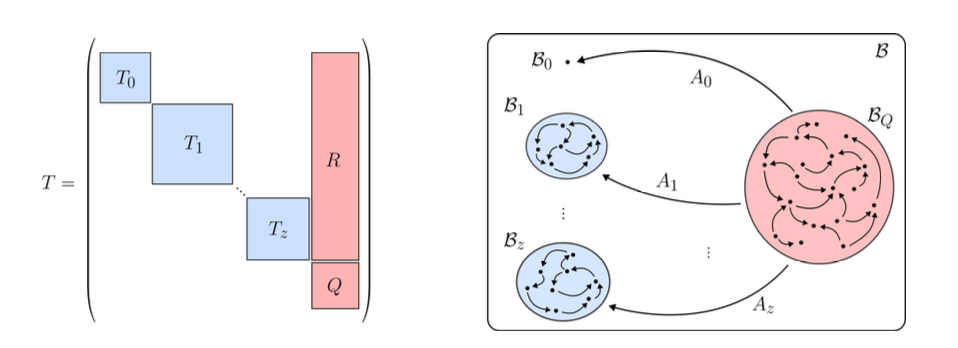

In [ ]:
from IPython.display import Image, display

# Percorso dell'immagine
image1 = "Img/Screenshot 2025-01-23 alle 11.32.53.png"
image2 = "Img/Screenshot 2025-01-23 alle 11.35.04.png"
image3 = "Img/Screenshot 2025-01-22 alle 11.21.30.png"
image4 = 'Img/Screenshot 2025-01-22 alle 16.47.42.png'

display(Image(filename=image4, width=300, height=200))
display(Image(filename=image1, width=500, height=400))
display(Image(filename=image2, width=500, height=400))
display(Image(filename=image3, width=500, height=400))

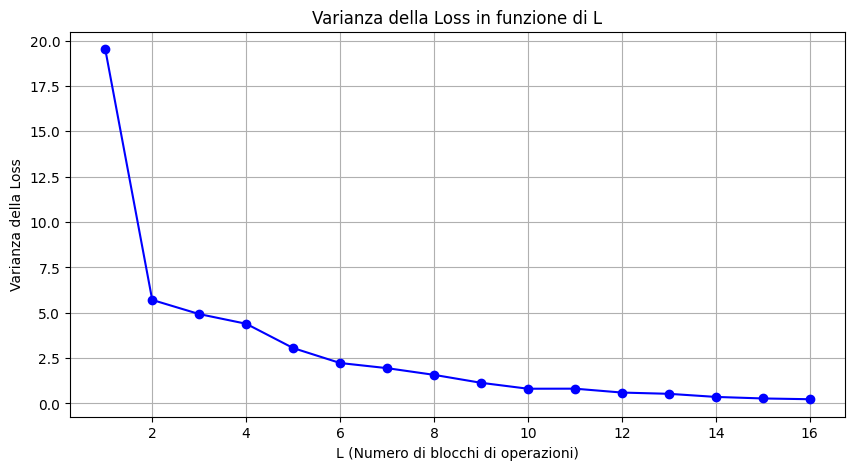

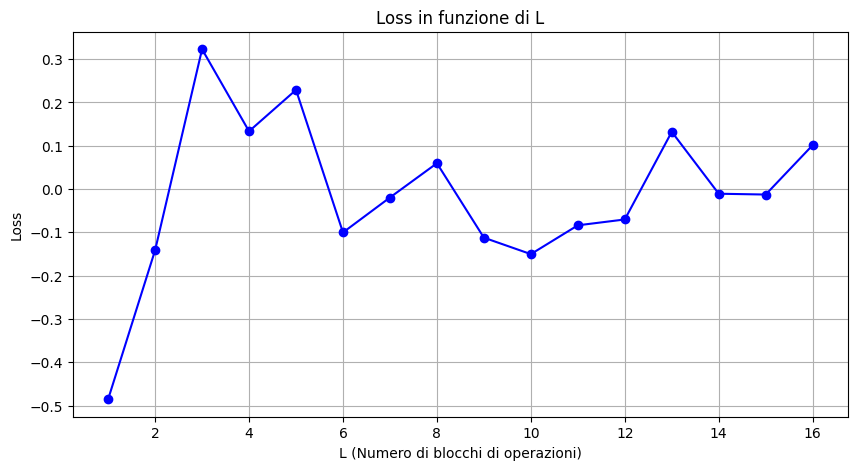

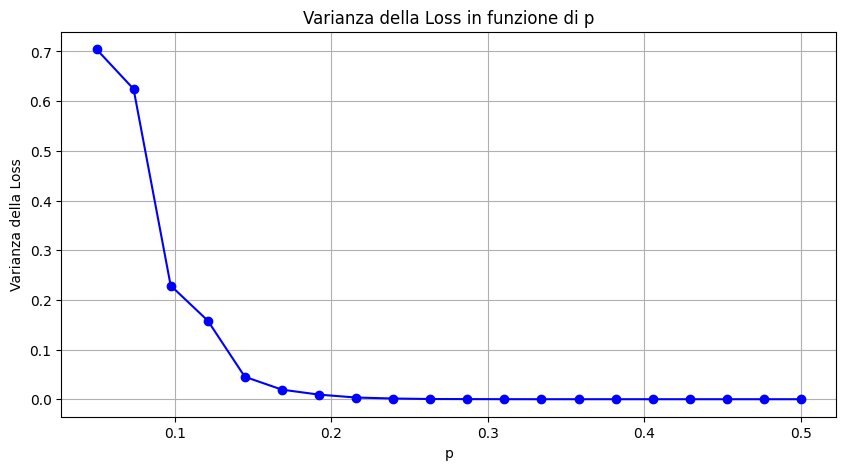

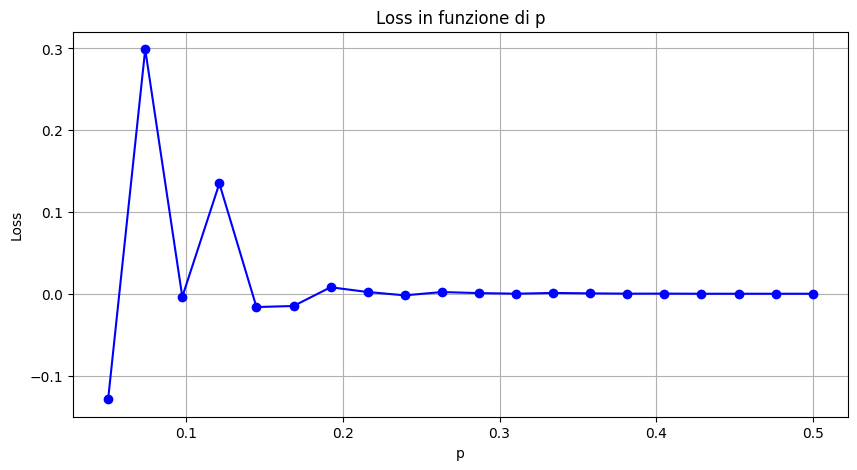

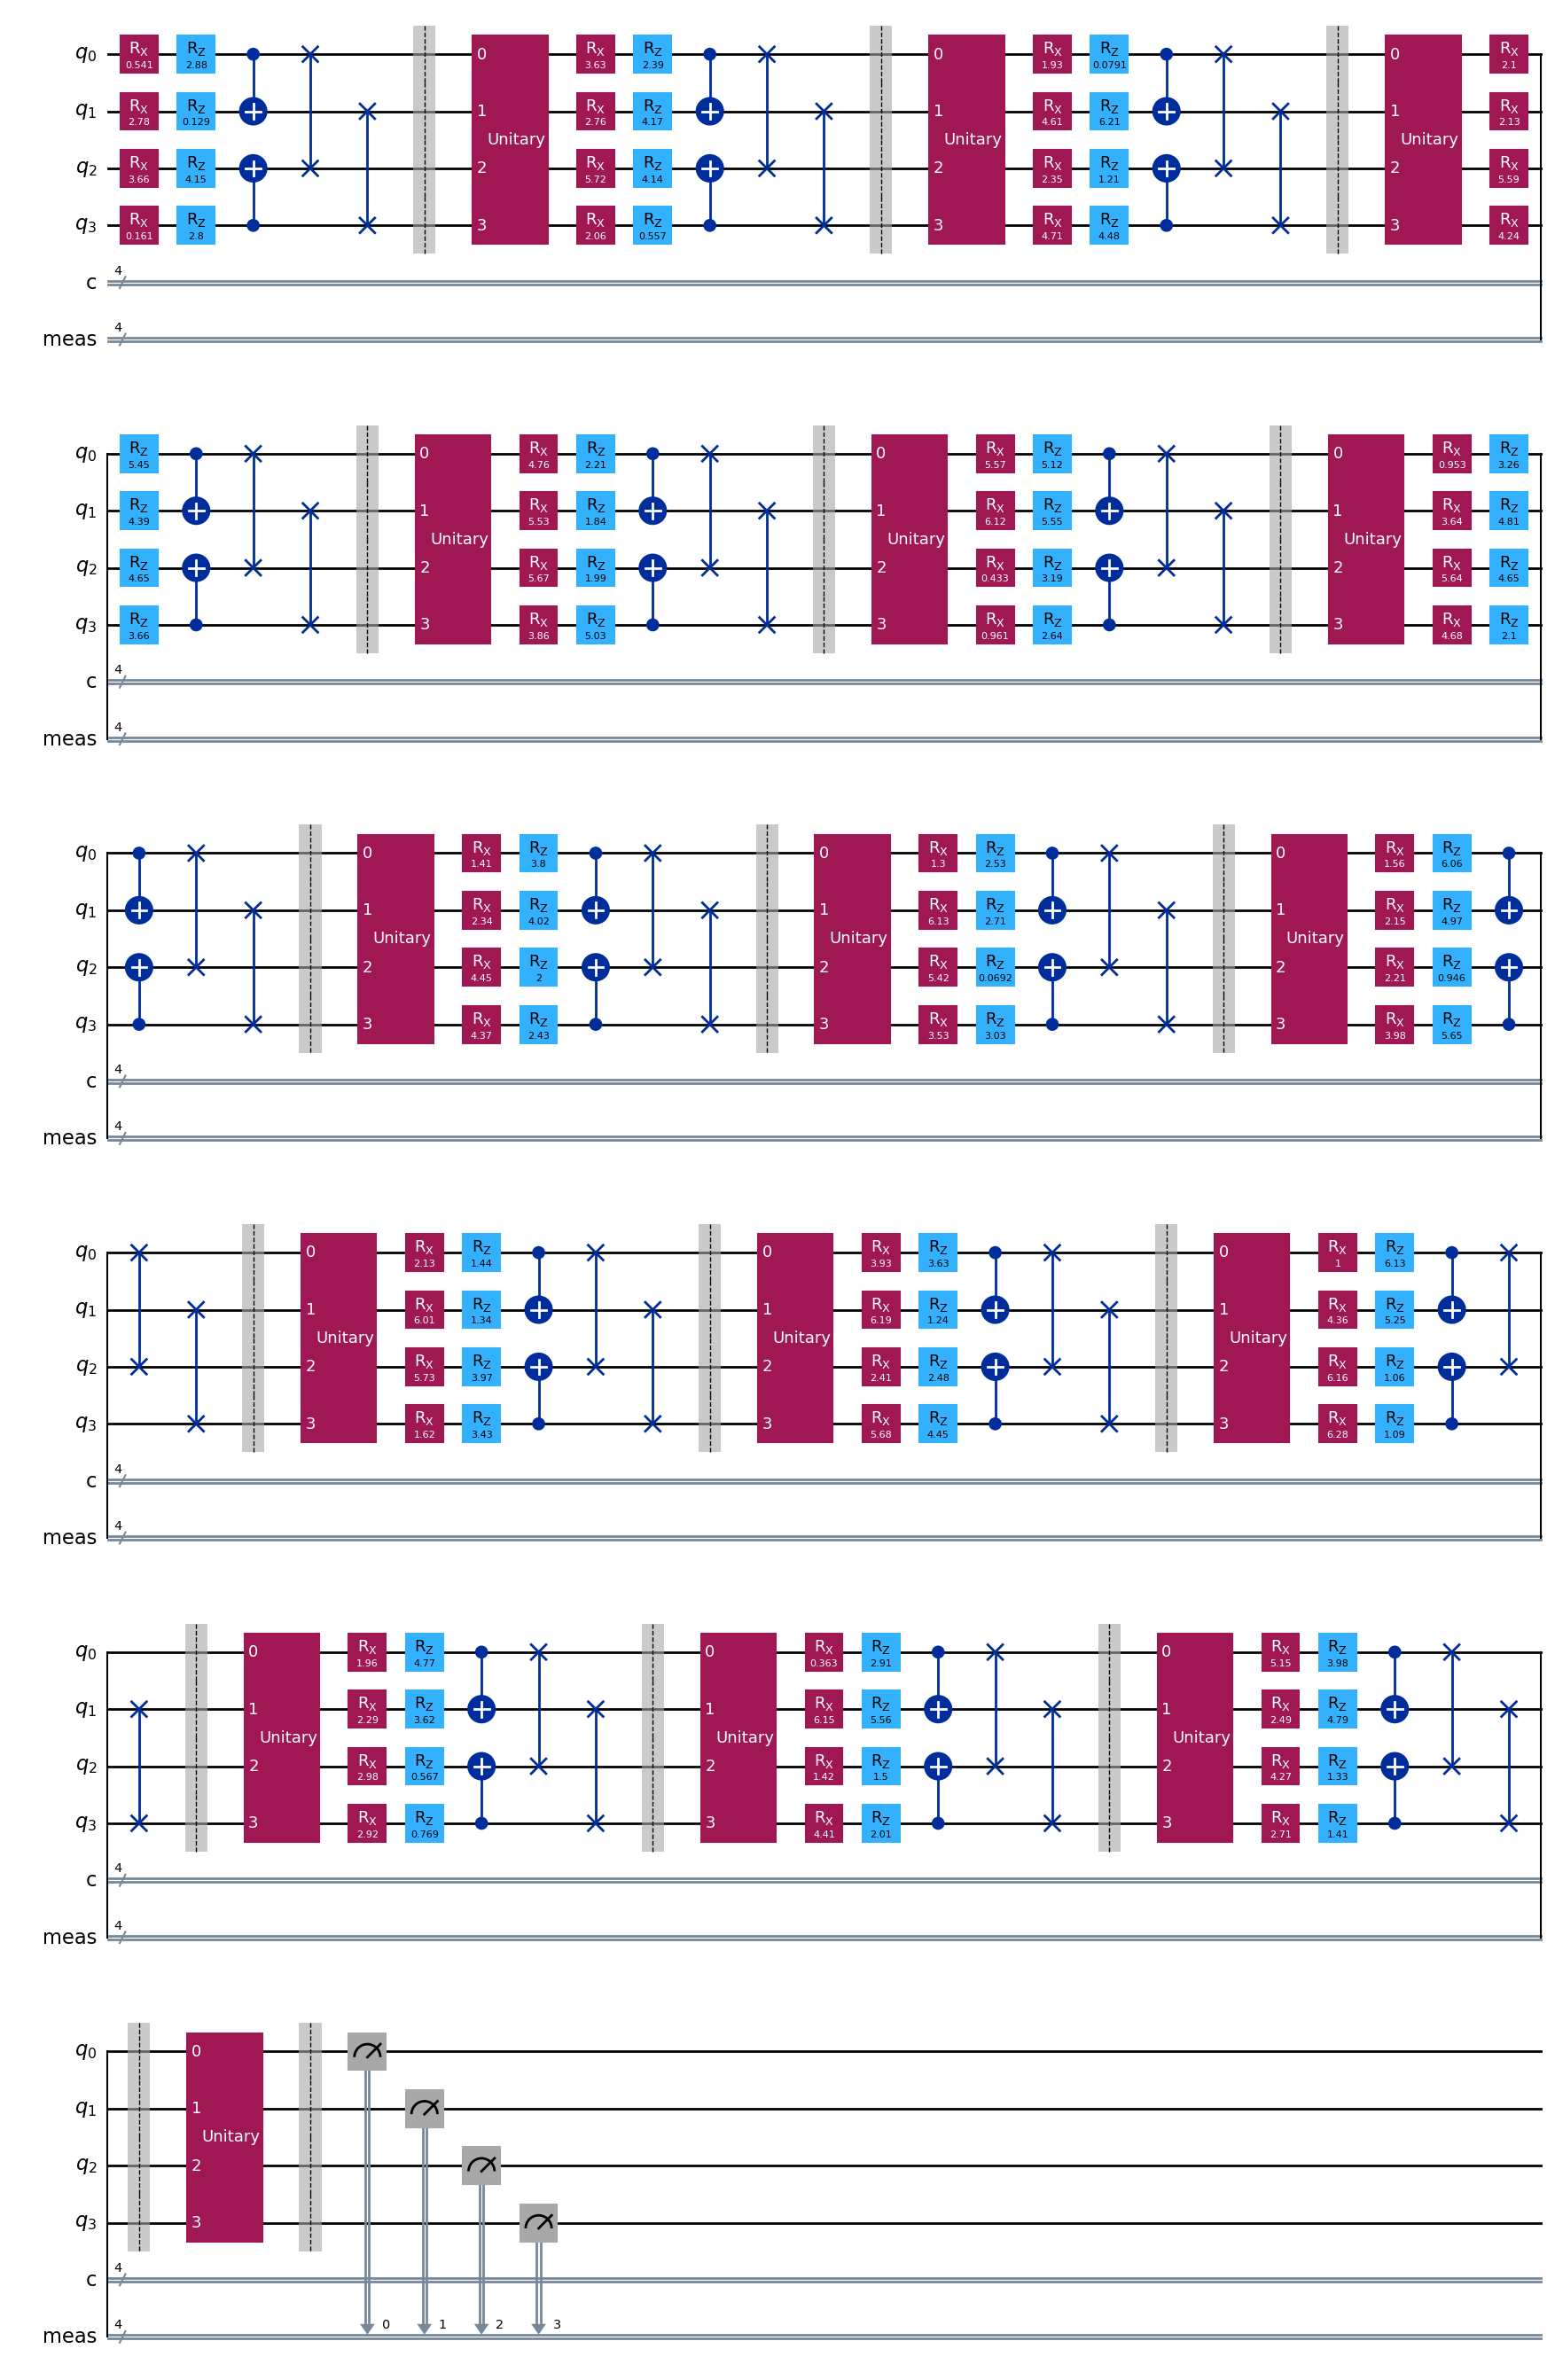

In [ ]:
import qiskit as qc
from qiskit_aer import Aer
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, Operator, SparsePauliOp, Kraus
import matplotlib.pyplot as plt

# Parametri
n = 4  # Numero di qubit
shots = 50  # Numero di esecuzioni
L_values_range = 16  # Numero massimo di blocchi di operazioni (abbassato per visualizzazione)
p = 0.1  # Probabilità di applicare lo stato GHZ
h = 1  # Coefficiente nell'Hamiltoniano

def generate_random_parameters(n):
    """Genera parametri casuali per rotazioni su n qubit."""
    return 2 * np.pi * np.random.rand(2 * n)

def create_ghz_state(n):
    """Genera lo stato GHZ per n qubit come matrice densità."""
    ghz_circuit = QuantumCircuit(n)
    ghz_circuit.h(0)
    for i in range(1, n):
        ghz_circuit.cx(0, i)
    return DensityMatrix.from_instruction(ghz_circuit)

# Creazione dello stato GHZ
ghz_state = create_ghz_state(n)

# Definizione degli operatori di Kraus
def apply_kraus_noise(rho, p, ghz_state):
    """Applica il canale di Kraus non-unitale, con stato GHZ usato con probabilità p."""
    I_n = np.eye(2**n)  # Identità su n qubit
    K0 = np.sqrt(1 - p) * I_n
    K1 = np.sqrt(p) * ghz_state.data  # Stato GHZ come matrice densità
    kraus_operators = [K0, K1]
    kraus_sum = sum(K @ rho.data @ K.conj().T for K in kraus_operators)
    return DensityMatrix(kraus_sum)

# Creazione dell'Hamiltoniano W
pauli_strings = []
coefficients = []

for k in range(n):
    coeff = h * 2**(n / 2)  # Coefficiente del termine
    coefficients.append(coeff)
    # Stringa di Pauli per Z_k ⊗ Z_{k+1}
    pauli_string = ['I'] * n
    pauli_string[k] = 'Z'  # Z_k
    pauli_string[(k + 1) % n] = 'Z'  # Z_{k+1} (periodico)
    pauli_strings.append("".join(pauli_string))

# Creazione dell'Hamiltoniano come SparsePauliOp
W = SparsePauliOp(pauli_strings, coeffs=np.array(coefficients))

simulator = Aer.get_backend('aer_simulator')

# Lista per memorizzare i valori di L per ogni valore di L (da 1 a L_values_range)
L_values_all = {L: [] for L in range(1, L_values_range + 1)}

# Esegui per ogni valore di L (da 1 a L_values_range)
for L in range(1, L_values_range + 1):

    # Lista per memorizzare i valori di L per i 100 ripetizioni (shots)
    L_values_shots = []

    for _ in range(shots):

        circuit = QuantumCircuit(n, n)
        rho = DensityMatrix.from_instruction(circuit)  # Stato iniziale |0...0⟩⟨0...0|

        for step in range(L):
            # Applica rotazioni casuali
            parameters = generate_random_parameters(n)

            for i in range(n):
                circuit.rx(parameters[2 * i], i)
                circuit.rz(parameters[2 * i + 1], i)

            # Applica i CNOT e gli swap
            circuit.cx(0, 1)
            circuit.cx(3, 2)
            circuit.swap(0, 2)
            circuit.swap(1, 3)

            rho = apply_kraus_noise(rho, p, ghz_state)
            circuit.barrier()  # Per separare visivamente gli step
            circuit.append(Operator(np.eye(2**n)), range(n))

              # Aggiorna rho con il canale di Kraus
            # Evoluzione della matrice densità (aggiorna rho)
            rho = rho.evolve(Operator(circuit))  # Evolvi con il circuito


        # Creazione dell'Hamiltoniano W e calcolo della Loss
        circuit.measure_all()
        W_matrix = W.to_matrix()
        L_value = np.trace(W_matrix @ rho.data)
        L_values_shots.append(L_value)

    L_values_all[L] = L_values_shots

# Calcola la media e la varianza per ogni valore di L (da 1 a L_values_range)
L_means = {L: np.mean(L_values_all[L]) for L in range(1, L_values_range + 1)}
L_variances = {L: np.var(L_values_all[L]) for L in range(1, L_values_range + 1)}

# Plot della varianza in funzione di L
L_range = list(L_variances.keys())  # Intervallo di L
var_values = list(L_variances.values())  # Valori di varianza corrispondenti
L_values = list(L_means.values())

plt.figure(figsize=(10, 5))  # Imposta la dimensione della figura
plt.plot(L_range, var_values, marker='o', linestyle='-', color='b')  # Grafico della varianza
plt.xlabel('L (Numero di blocchi di operazioni)')  # Etichetta asse x
plt.ylabel('Varianza della Loss')  # Etichetta asse y
plt.title('Varianza della Loss in funzione di L')  # Titolo del grafico
plt.grid(True)  # Aggiungi la griglia
plt.show()  # Mostra il grafico

plt.figure(figsize=(10, 5))  # Imposta la dimensione della figura
plt.plot(L_range, L_values, marker='o', linestyle='-', color='b')  # Grafico della Loss
plt.xlabel('L (Numero di blocchi di operazioni)')  # Etichetta asse x
plt.ylabel('Loss')  # Etichetta asse y
plt.title('Loss in funzione di L')  # Titolo del grafico
plt.grid(True)  # Aggiungi la griglia
plt.show()  # Mostra il grafico


p_values = np.linspace(0.05, 0.5, 20)


L_values_all = {p_val: [] for p_val in p_values}

# Esegui per ogni valore di p
for p in p_values:

    # Lista per memorizzare i valori di L per le esecuzioni
    L_values_shots = []

    for _ in range(shots):
        circuit = QuantumCircuit(n, n)
        rho = DensityMatrix.from_instruction(circuit)  # Stato iniziale |0...0⟩⟨0...0|

        for step in range(L_values_range):  # Iterazione per L
            # Applica rotazioni casuali
            parameters = generate_random_parameters(n)

            for i in range(n):
                circuit.rx(parameters[2 * i], i)
                circuit.rz(parameters[2 * i + 1], i)

            # Applica i CNOT e gli swap
            circuit.cx(0, 1)
            circuit.cx(3, 2)
            circuit.swap(0, 2)
            circuit.swap(1, 3)

            rho = apply_kraus_noise(rho, p, ghz_state)
            circuit.barrier()  # Per separare visivamente gli step
            circuit.append(Operator(np.eye(2**n)), range(n))

            rho = rho.evolve(Operator(circuit))  # Evolvi con il circuito

        circuit.measure_all()
        # Calcolo della Loss
        W_matrix = W.to_matrix()

        simulator = Aer.get_backend('aer_simulator')

        L_value = np.trace(W_matrix @ rho.data)
        L_values_shots.append(L_value)

    L_values_all[p] = L_values_shots

# Calcola la media e la varianza per ogni valore di p
L_means = {p: np.mean(L_values_all[p]) for p in p_values}
L_variances = {p: np.var(L_values_all[p]) for p in p_values}

# Plot della varianza in funzione di p
plt.figure(figsize=(10, 5))
plt.plot(p_values, list(L_variances.values()), marker='o', linestyle='-', color='b')
plt.xlabel('p')
plt.ylabel('Varianza della Loss')
plt.title('Varianza della Loss in funzione di p')
plt.grid(True)
plt.show()

# Plot della Loss in funzione di p
plt.figure(figsize=(10, 5))
plt.plot(p_values, list(L_means.values()), marker='o', linestyle='-', color='b')
plt.xlabel('p')
plt.ylabel('Loss')
plt.title('Loss in funzione di p')
plt.grid(True)
plt.show()


circuit.draw('mpl')

Prova 2, con osservabile Y  @  X e rotazioni iniziali xy

[((0, 0), 0.9999999999999996), ((1, 0), (0.9999999999999996+0j)), ((0, 1), (0.9999999999999996+0j)), ((1, 1), (0.9999999999999996+0j))]


/usr/local/lib/python3.11/dist-packages/matplotlib/transforms.py:757: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


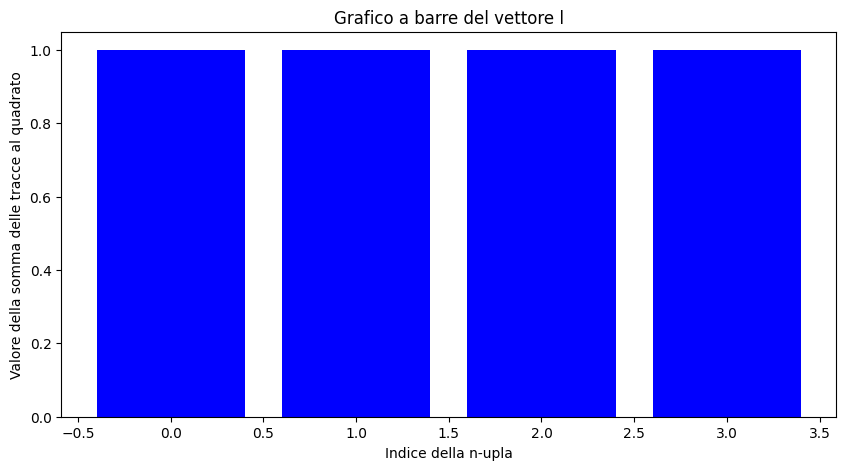

Chiavi ordinate (n-uple): [(0, 0), (1, 0), (0, 1), (1, 1)]


<ipython-input-93-bf4d698d1362>:113: ComplexWarning: Casting complex values to real discards the imaginary part
  T[i, j] = sum_value


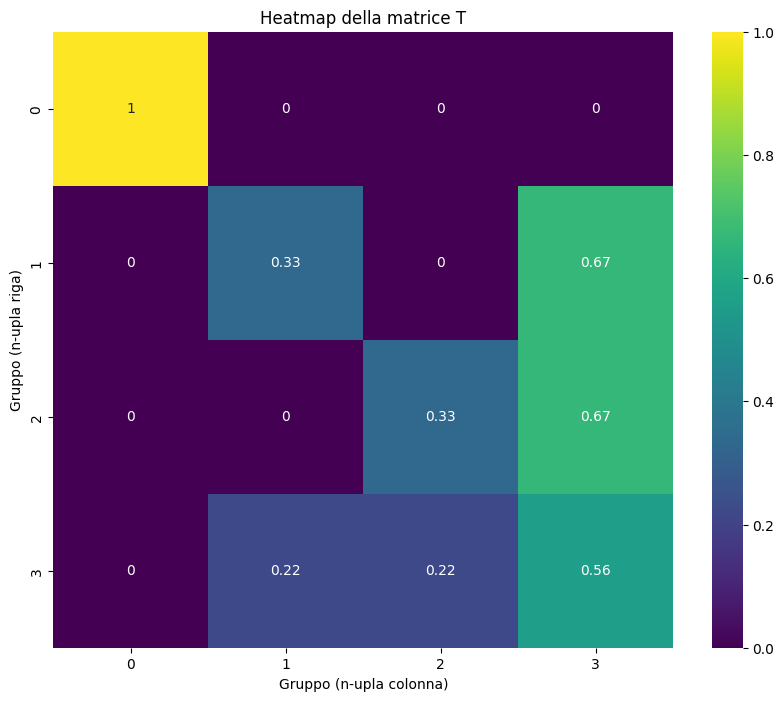

Matrice T ridotta in forma block upper-triangolare:
[[1.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.66666667]
 [0.         0.         0.33333333 0.66666667]
 [0.         0.22222222 0.22222222 0.55555556]]
Permutazione degli indici: [0, 1, 2, 3]


In [93]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Definizione delle matrici di Pauli e dell'identità
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Dividi ogni array per la radice di due
sqrt_2 = np.sqrt(2)
I = I / sqrt_2
X = X / sqrt_2
Y = Y / sqrt_2
Z = Z / sqrt_2

# Dizionario per riferire i simboli
pauli_matrices = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
matrix_labels = ['I', 'X', 'Y', 'Z']

# Numero di qubit (variabile)
n = 2  # Può essere modificato

# Generazione di tutte le combinazioni possibili
tensor_products = []
labels = []

for combination in itertools.product(matrix_labels, repeat=n):
    # Costruzione del prodotto tensore
    tensor_product = pauli_matrices[combination[0]]
    for label in combination[1:]:
        tensor_product = np.kron(tensor_product, pauli_matrices[label])

    # Creazione della n-upla binaria: 1 se non è identità, 0 se è identità
    binary_tuple = tuple(1 if label != 'I' else 0 for label in combination)

    tensor_products.append((binary_tuple, tensor_product))
    labels.append((combination, binary_tuple))

# Ordinamento delle combinazioni in base alla rappresentazione 'bit' crescente
# Consideriamo il primo elemento della tupla come il bit meno significativo:
tensor_products.sort(key=lambda item: sum(bit*(2**i) for i, bit in enumerate(item[0])))
labels.sort(key=lambda item: sum(bit*(2**i) for i, bit in enumerate(item[1])))

# Generazione della matrice H e del suo trasposto
dim = 2**n
H = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
H_t = H.conj().T

# Dizionario per memorizzare le somme delle tracce al quadrato per ogni etichetta
trace_sums_dict = defaultdict(float)

# Calcolo delle somme delle tracce al quadrato per ogni etichetta
for label, matrix in tensor_products:
    trace_val = np.trace(H @ matrix )
    trace_sums_dict[label] += trace_val**2

# Converti il dizionario in una lista di tuple (etichetta, somma delle tracce al quadrato)
trace_sums = list(trace_sums_dict.items())

print(trace_sums)

# Stampa del vettore delle somme delle tracce al quadrato
#print("Vettore delle somme delle tracce al quadrato:")
#print(trace_sums)

import matplotlib.pyplot as plt

# Estrai le somme delle tracce al quadrato dal dizionario trace_sums_dict
trace_sums_values = list(trace_sums_dict.values())

# Grafico a barre del vettore l
plt.figure(figsize=(10, 5))
plt.bar(range(len(trace_sums_values)), trace_sums_values, color='blue')
plt.xlabel("Indice della n-upla")
plt.ylabel("Valore della somma delle tracce al quadrato")
plt.title("Grafico a barre del vettore l")
plt.show()

# Raggruppamento delle matrici per n-upla (sottogruppo di appartenenza)
groups = {}
for binary_tuple, matrix in tensor_products:
    groups.setdefault(binary_tuple, []).append(matrix)

# Ordinamento delle chiavi in base alla notazione 'bit' crescente (bit meno significativo come primo elemento)
sorted_keys = sorted(groups.keys(), key=lambda key: sum(bit*(2**i) for i, bit in enumerate(key)))
print("Chiavi ordinate (n-uple):", sorted_keys)

# Calcolo della matrice T
num_groups = len(sorted_keys)
T = np.zeros((num_groups, num_groups))

for i, key_R in enumerate(sorted_keys):
    group_R = groups[key_R]
    # d calcolato per il gruppo della riga: prodotto di 3 per ogni bit uguale a 1, 1 per ogni 0
    d = np.prod([3 if bit == 1 else 1 for bit in key_R])
    for j, key_C in enumerate(sorted_keys):
        group_C = groups[key_C]
        sum_value = 0
        # Somma sulle coppie (R, C) appartenenti rispettivamente al gruppo della riga e al gruppo della colonna
        for R_matrix in group_R:
            for C_matrix in group_C:
                value = np.trace(H_t @ R_matrix @ H @ C_matrix)
                sum_value += value**2 / d
        T[i, j] = sum_value

# Stampa della matrice T print("Matrice T:")
#print(T)

# Heatmap della matrice T
plt.figure(figsize=(10, 8))
sns.heatmap(T, annot=True, cmap="viridis")
plt.xlabel("Gruppo (n-upla colonna)")
plt.ylabel("Gruppo (n-upla riga)")
plt.title("Heatmap della matrice T")
plt.show()

#------------------------------------------
import numpy as np
import networkx as nx

def block_upper_triangular(T, tol=1e-14):
    """
    Data una matrice T (non negativa), restituisce la matrice T_ridotta
    in forma block upper-triangolare e la permutazione dei nodi.

    Parameters:
        T (numpy.ndarray): matrice di input.
        tol (float): soglia per considerare un elemento come zero.

    Returns:
        T_perm (numpy.ndarray): T riordinata in forma block upper-triangolare.
        perm (list): lista di indici che definisce la permutazione.
    """
    n = T.shape[0]
    G = nx.DiGraph()
    G.add_nodes_from(range(n))

    # Aggiungiamo un arco da i a j se T[i, j] supera la soglia.
    for i in range(n):
        for j in range(n):
            if T[i, j] > tol:
                G.add_edge(i, j)

    # Troviamo le componenti fortemente connesse
    scc = list(nx.strongly_connected_components(G))

    # Creiamo una mappa: nodo -> id della componente
    comp_id = {}
    for idx, comp in enumerate(scc):
        for node in comp:
            comp_id[node] = idx

    # Costruiamo il grafo delle componenti contratte
    comp_graph = nx.DiGraph()
    for idx in range(len(scc)):
        comp_graph.add_node(idx)
    for i, j in G.edges():
        ci = comp_id[i]
        cj = comp_id[j]
        if ci != cj:
            comp_graph.add_edge(ci, cj)

    # Ordiniamo le componenti in ordine topologico
    sorted_comps = list(nx.topological_sort(comp_graph))

    # Costruiamo la permutazione raggruppando i nodi per componente
    perm = []
    for comp_idx in sorted_comps:
        # Ordinamento interno per riproducibilità
        nodes_in_comp = sorted(list(scc[comp_idx]))
        perm.extend(nodes_in_comp)

    # Applichiamo la permutazione a T
    T_perm = T[np.ix_(perm, perm)]
    return T_perm, perm

# Esempio d'uso:
# Supponiamo di avere una matrice T non negativa (ad esempio quella del LTM)


T_ridotta, permutazione = block_upper_triangular(T)
print("Matrice T ridotta in forma block upper-triangolare:")
print(T_ridotta)
print("Permutazione degli indici:", permutazione)